In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

# Loading Dataset

In [2]:
df = pd.read_csv('./database/csv_files/Csv_heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Data Exploration & Cleaning

In [3]:
# summery
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
# statistical summery
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#### Null values

In [5]:
df.isnull().sum() # no null values

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

#### imbalance in dataset

In [8]:
df.HeartDisease.value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [10]:
df.HeartDisease.value_counts()[0]/df.HeartDisease.value_counts()[1] # its not much imbalanced

0.8070866141732284

#### Outliers

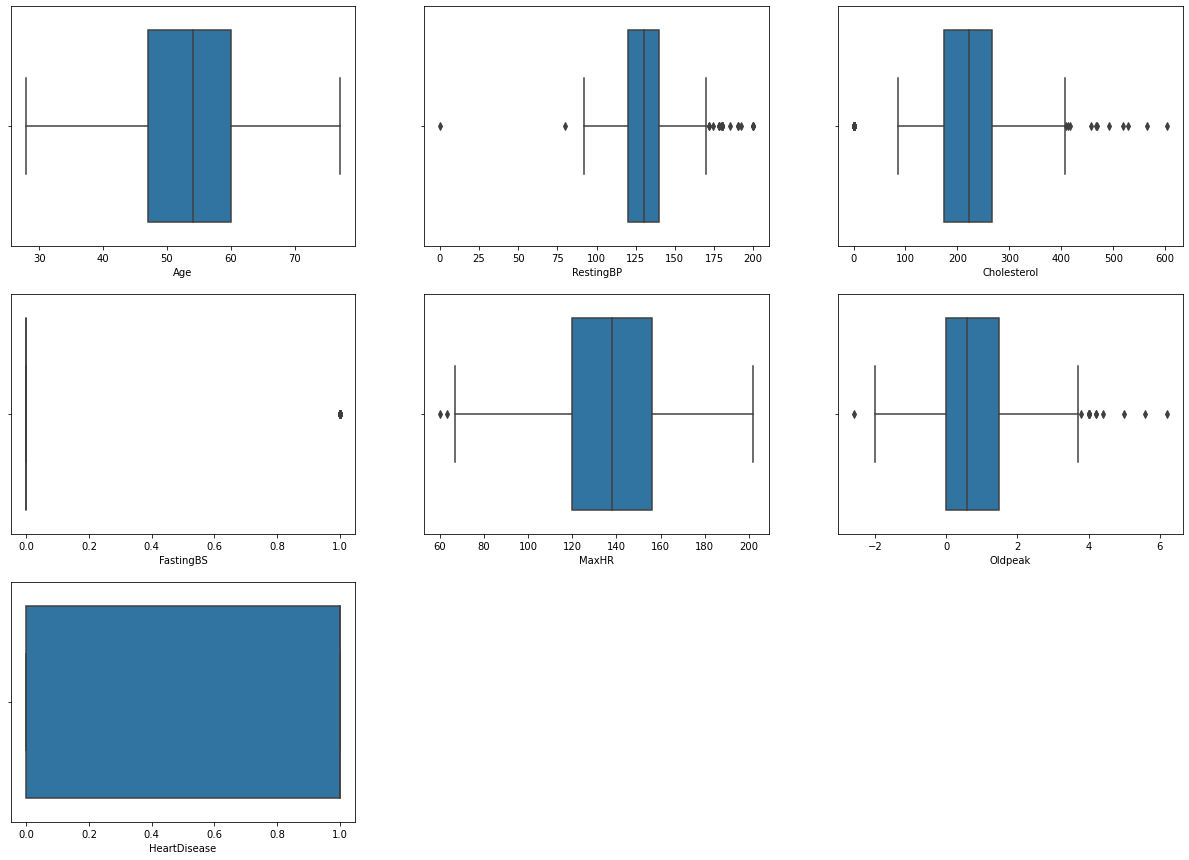

In [53]:
#  box plot

numeric_cols = df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(21,15))
for i in range(len(numeric_cols)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=numeric_cols[i], data=df)

In [47]:
# removing catagorical encoded features

numeric_cols = numeric_cols.tolist()
numeric_cols.remove('FastingBS')
numeric_cols.remove('HeartDisease')
numeric_cols

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [49]:
# calculating Z-scores for each numeric_cols

df2 = df.copy()

def z_score(col,df):
    return (df[col] - df[col].mean())/df[col].std()

for i in numeric_cols[:-1]:
    df2[i+'_z_score'] = z_score(i,df)

df2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_z_score,RestingBP_z_score,Cholesterol_z_score,MaxHR_z_score
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,-1.432359,0.410685,0.824621,1.382175
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,-0.478223,1.490940,-0.171867,0.753746
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,-1.750404,-0.129442,0.769768,-1.524307
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,-0.584238,0.302660,0.138964,-1.131539
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0.051853,0.950812,-0.034736,-0.581664


In [50]:
# Reomoving all outliers

df3 = df2.copy()

for i in numeric_cols[:-1]:
    df3 = df3[(df3[i+'_z_score']>-3) & (df3[i+'_z_score']<3)]

df3.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_z_score,RestingBP_z_score,Cholesterol_z_score,MaxHR_z_score
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,-1.432359,0.410685,0.824621,1.382175
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,-0.478223,1.490940,-0.171867,0.753746
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,-1.750404,-0.129442,0.769768,-1.524307
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,-0.584238,0.302660,0.138964,-1.131539
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0.051853,0.950812,-0.034736,-0.581664


In [55]:
# outliers removed

df2.shape[0] - df3.shape[0]

12

#### Encoding catagorical variables

In [63]:
df4 = df3[df.columns]

cat_cols = df4.select_dtypes(include=['O'])

encoder = LabelEncoder()
for i in cat_cols:
    df4[i] = encoder.fit_transform(df4[i])

df4.head()

<ipython-input-63-9da6af396e80>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4[i] = encoder.fit_transform(df4[i])


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


#### Normalization

In [64]:
scaler = MinMaxScaler()
df5 = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns)
df5.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0.244898,1.0,0.333333,0.571429,0.557915,0.0,0.5,0.784173,0.0,0.295455,1.0,0.0
1,0.428571,0.0,0.666667,0.761905,0.347490,0.0,0.5,0.669065,0.0,0.409091,0.5,1.0
2,0.183673,1.0,0.333333,0.476190,0.546332,0.0,1.0,0.251799,0.0,0.295455,1.0,0.0
3,0.408163,0.0,0.000000,0.552381,0.413127,0.0,0.5,0.323741,1.0,0.465909,0.5,1.0
4,0.530612,1.0,0.666667,0.666667,0.376448,0.0,0.5,0.424460,0.0,0.295455,1.0,0.0


# train test split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df5.drop('HeartDisease', axis=1), 
                                                    df5.HeartDisease, stratify=df5.HeartDisease, random_state=45)

# SVM

#### SVM without Bagging

In [72]:
# crossval scores
scores = cross_val_score(SVC(),X_train,y_train,cv = 10)

print(scores)
scores.mean()

[0.85294118 0.85294118 0.86764706 0.88235294 0.89705882 0.86764706
 0.83823529 0.91176471 0.72058824 0.95522388]


0.8646400351185249

In [70]:
# test scores
svm_model = SVC()

svm_model.fit(X_train,y_train)
svm_model.score(X_test,y_test)

0.8678414096916299

#### SVM with bagging

In [73]:
# oob score
bagged_svm = BaggingClassifier(base_estimator=SVC(),n_estimators=50,max_samples=0.8,oob_score=True,random_state=456)

bagged_svm.fit(X_train,y_train)
bagged_svm.oob_score_

0.8600883652430045

In [74]:
# cross val score

scores = cross_val_score(bagged_svm,X_train,y_train,cv = 10)

print(scores)
scores.mean()

[0.85294118 0.83823529 0.85294118 0.88235294 0.89705882 0.88235294
 0.83823529 0.91176471 0.72058824 0.94029851]


0.861676909569798

In [75]:
# test scores

bagged_svm.score(X_test,y_test)

0.8810572687224669